# Discover project Ames housing data

# Aanpak van dit project

## Door: Eric Ruis, Laurence Frank

Eerste fase is het begrijpen van de data set. Wat betekenen de variabelen (domein kennis)? Hoe zijn de variablen verdeeld? Zijn er missende waarden, outliers? Welke variabelen correleren met elkaar en met de uitkomst maat?



## Business Understanding

Het doel is om de prijs van huizen te voorspellen op basis van een tachtigtal kenmerken van de huizen. 



## Data Understanding

De data staan uitgebreid beschreven op deze Kaggle webpagina: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data


De data set bestaat uit 80 variabelen die verschillende aspecten van het huis beschrijven in de volgende categorieen: de kenmerken van het huis zelf (indeling, oppervlak, stijl, bouwjaar, kwaliteit, etc), kenmerken van de grond waarop het huis staat en kenmerken van de buurt. 

Op basis van de betekenis van de variabelen, besluiten we de volgende variabelen uit te sluiten van de analyses:

Condition2: Proximity to various conditions (if more than one is present)
Deze variabele gaat waarschijnlijk niet veel informatie toevoegen ten opzichte van Condition1.


We beginnen met een setup van python met de meest gebruikte libraries.

In [275]:
# PEP-8: group imports from standard library first, alphabetical order
from pathlib import Path # use pathlib for working with paths
import sys
import tarfile
import warnings

# imports from third-party modules
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import requests
from requests.compat import urljoin
import sklearn
import seaborn as sns

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)



# Initialize the random number generator at a specific state to be able reproduce
# the random selections in this notebook
np.random.seed(42)


**Importeren van de data**

In [276]:
ames = pd.read_csv("https://github.com/jads-nl/discover-projects/blob/main/ames-housing/AmesHousing.csv?raw=true")
ames.shape

(2930, 82)

In [165]:
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

### Exploreer de variabelen

Op basis van "gezond verstand" gaan we na of bepaalde variabelen een verband hebben met de uitkomst variabele `SalePrice`. Dit is een globale check op de data om te kijken of we variabelen waar nauwelijks informatie in zit, weg kunnen laten. 

We zien al in de informatie over de data, hierboven, dat `Alley`, `Pool QC` en `Misc Feature` nauwelijks observaties hebben. 


Van `Neighborhood` verwachten we dat er een verband zal zijn met de verkoopprijs van het huis. In de boxplot hieronder is te zien dat veel variatie is in de verkoopprijs naar gelang de buurt waar het huis staat.

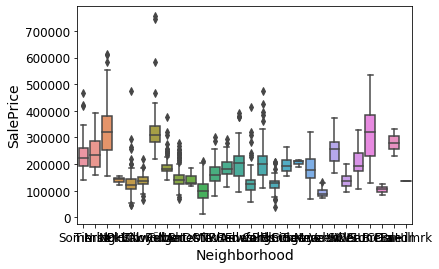

In [98]:
ax = sns.boxplot(x="Neighborhood", y="SalePrice", data=ames)

Toevoegen: toelichting waarom deze variabelen verwijderd worden. 

In [277]:
dropvars = ["Order", "PID", "Condition 1", "Condition 2", "BsmtFin Type 1", "BsmtFin Type 2", "Bsmt Qual", "Bsmt Cond", 
            "Bsmt Exposure", "Pool QC", "Fence", "Misc Feature", "Alley", "Heating", "Heating QC", 
            "Central Air", "Electrical", "Functional"]

ames.drop(dropvars, axis=1, inplace=True)  # Let op: vergeet inplace=True niet 
                                           # om aan te geven dat de verandering
                                           # in de dataframe en dat de oude versie door 
                                           # de nieuwe moet worden vervangen.
#ames = ames.drop(dropvars, axis=1)
    
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 64 columns):
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         2930 non-null object
Roof Matl          2930 non-null object
Exterior 1st       2930 non-null object
Exterior 2nd       2930 non-null object
Mas Vnr Type       2907 non-null object
Mas Vnr Area      

We ontdekken dat de training data set 80 variabelen bevat, terwijl de orginele data set er 82 heeft. We besluiten om zelf een training / test data set te maken met een verdeling van 70% (training) en 30% (test). 

In [156]:
traindata = ames.sample(frac = 0.7, random_state = 1)
traindata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 2126 to 502
Data columns (total 66 columns):
Order              2051 non-null int64
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1706 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         2051 non-null object
Roof Matl          2051 non-null object
Exterior 1st       2051 non-null object
Exterior 2nd      

We hebben nu de training data set aangemaakt, maar nu moeten we nog de test set construeren en die bestaat uit de resterende 30% van de rijen van de originele data set. Maar hoe ga je die nu uit de originele data set halen? Dat kan wel, met een identificerende variabele, bijvoorbeeld het object nummer, `PID` in de data set. Maar dat is wat omslachtig. We kunnen ook gewoon de ingebouwde functie `train_test_split` gebruiken. 

In [278]:
# Maak training data set en test set.
from sklearn.model_selection import train_test_split

traindata, testdata = train_test_split(ames, test_size=0.3)
traindata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 2210 to 860
Data columns (total 64 columns):
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1704 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         2051 non-null object
Roof Matl          2051 non-null object
Exterior 1st       2051 non-null object
Exterior 2nd       2051 non-null object
Mas Vnr Type       2037 non-null object
Mas Vnr Area    

In [189]:
traindata.head(20)

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
2270,20,RL,NaN,7777,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,11,2007,WD,Normal,178000
1322,70,RM,60.0,10800,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,184000
1341,20,RM,99.0,5940,Pave,IR1,Lvl,AllPub,FR3,Gtl,...,0,0,0,0,0,4,2008,ConLD,Abnorml,79000
790,20,RL,68.0,9571,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,6,2009,COD,Abnorml,60000
2659,75,RM,60.0,10800,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,10,2006,WD,Normal,163000
1127,60,FV,65.0,8125,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,5,2008,WD,Normal,205950
20,20,RL,105.0,11751,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,1,2010,COD,Normal,190000
2043,50,RM,60.0,10320,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,84,0,0,9,2007,COD,Abnorml,50000
649,20,RL,75.0,9533,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,100,0,0,0,0,8,2009,ConLD,Normal,102900
1081,120,RM,NaN,3940,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,5,2008,WD,Normal,219990


In [ ]:
traindata

In [90]:
testdata.shape

(879, 82)

In [169]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 879 entries, 753 to 1653
Data columns (total 64 columns):
MS SubClass        879 non-null int64
MS Zoning          879 non-null object
Lot Frontage       739 non-null float64
Lot Area           879 non-null int64
Street             879 non-null object
Lot Shape          879 non-null object
Land Contour       879 non-null object
Utilities          879 non-null object
Lot Config         879 non-null object
Land Slope         879 non-null object
Neighborhood       879 non-null object
Bldg Type          879 non-null object
House Style        879 non-null object
Overall Qual       879 non-null int64
Overall Cond       879 non-null int64
Year Built         879 non-null int64
Year Remod/Add     879 non-null int64
Roof Style         879 non-null object
Roof Matl          879 non-null object
Exterior 1st       879 non-null object
Exterior 2nd       879 non-null object
Mas Vnr Type       870 non-null object
Mas Vnr Area       870 non-null float64

## Checking the missing values

Visualize missing values of a `pandas` data frame: https://dev.to/tomoyukiaota/visualizing-the-patterns-of-missing-value-occurrence-with-python-46dj

Another package to explore missing value patterns: missingno

see: https://github.com/ResidentMario/missingno

https://www.kaggle.com/jpmiller/patterns-of-missing-data




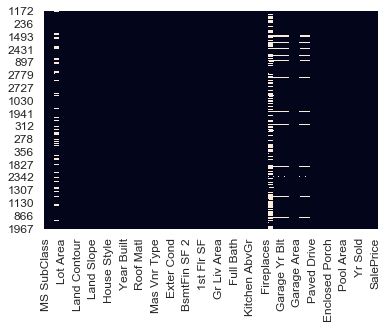

In [170]:
sns.heatmap(traindata.isnull(), cbar=False)

In [171]:
traindata.describe(exclude = np.object)

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2051.000000,1701.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2037.000000,2050.000000,2050.000000,...,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,56.591906,69.396238,10039.056558,6.100926,5.573866,1971.251585,1984.280351,102.124693,451.730732,52.960488,...,94.313506,47.645539,22.730863,2.840078,15.680644,1.709898,59.342272,6.205753,2007.786933,181670.901999
std,42.599825,23.072047,7096.923030,1.406970,1.110825,30.718884,21.042973,179.715495,467.007416,174.402347,...,126.262841,68.161434,60.984370,26.682026,55.875462,31.317698,663.963259,2.696626,1.317775,80445.847840
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,13100.000000
25%,20.000000,59.000000,7500.000000,5.000000,5.000000,1953.000000,1965.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129225.000000
50%,50.000000,68.000000,9480.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,377.500000,0.000000,...,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,161000.000000
75%,70.000000,80.000000,11589.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,747.000000,0.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,215000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1424.000000,742.000000,552.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [172]:
traindata.describe(include = np.object)

,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Bldg Type,House Style,...,Foundation,Kitchen Qual,Fireplace Qu,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Sale Type,Sale Condition
count,2051,2051,2051,2051,2051,2051,2051,2051,2051,2051,...,2051,2051,1068,1950,1948,1948,1948,2051,2051,2051
unique,7,2,4,4,2,5,3,28,5,8,...,6,5,5,6,3,5,5,3,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,1Fam,1Story,...,PConc,TA,Gd,Attchd,Unf,TA,TA,Y,WD,Normal
freq,1577,2043,1296,1840,2050,1498,1955,301,1717,1037,...,933,1030,545,1214,860,1842,1878,1851,1774,1701


Verdeling van de uitkomst variabele, `SalePrice` bekijken. 

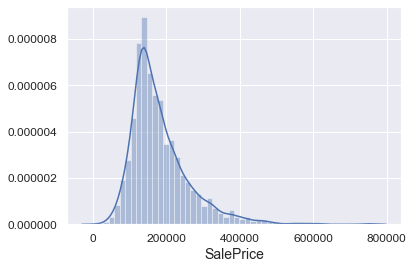

In [173]:
sns.distplot(traindata['SalePrice'])

Het is duidelijk dat de verkoop prijs scheef verdeeld is. In de modelering fase nemen we de log van deze variabele. 

In [174]:
traindata['SalePrice'].skew()

1.7269339919460922

## Missende waarden aanpassen



In [74]:
# dit is een probeersel
#traindata_obj = traindata.select_dtypes(include=['object'])
#traindata_obj.info()


In [75]:
#traindata_obj.head()

Nog een probeersel: kijken of we alle NaN's in objecten kunnen vervangen door '100'. We proberen dit op de kolom `Alley`.

In [76]:
#traindata_obj['Alley'].fillna('100', inplace = True)
#traindata_obj.head()

In [279]:
traindata.reset_index(inplace=True, drop=True)
traindata.head(10)

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,90,RH,82.0,6270,Pave,Reg,HLS,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,145000
1,20,RL,65.0,25095,Pave,IR1,Low,AllPub,Inside,Sev,...,0,0,60,0,0,6,2009,WD,Partial,143000
2,60,RL,60.0,8238,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,5,2006,WD,Normal,183500
3,120,RM,35.0,3907,Pave,IR1,HLS,AllPub,Inside,Mod,...,0,0,0,0,0,3,2010,WD,Normal,162500
4,120,RM,NaN,3072,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,5,2006,WD,Normal,178740
5,70,RM,90.0,9900,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,117500
6,20,RL,74.0,8536,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,4,2007,New,Partial,155000
7,120,RM,44.0,3842,Pave,IR1,HLS,AllPub,Inside,Mod,...,0,0,155,0,0,1,2008,WD,Normal,275000
8,20,RL,NaN,32668,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,200,0,0,0,0,3,2007,WD,Alloca,200624
9,85,RL,150.0,14137,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,171,0,0,11,2008,ConLD,Normal,173000


In [242]:
na_rows1 = traindata[traindata["Mas Vnr Area"].isna()]
na_rows1["Mas Vnr Area"]

181    NaN
197    NaN
408    NaN
443    NaN
573    NaN
1006   NaN
1038   NaN
1196   NaN
1394   NaN
1501   NaN
1600   NaN
1705   NaN
1716   NaN
1748   NaN
Name: Mas Vnr Area, dtype: float64

In [243]:
na_rows2 = traindata[traindata["Lot Frontage"].isna()]
na_rows2["Lot Frontage"]

0      NaN
5      NaN
11     NaN
13     NaN
17     NaN
        ..
2020   NaN
2022   NaN
2028   NaN
2030   NaN
2048   NaN
Name: Lot Frontage, Length: 329, dtype: float64

In [244]:
traindata.iloc[0]

MS SubClass            60
MS Zoning              RL
Lot Frontage          NaN
Lot Area            18450
Street               Pave
                   ...   
Mo Sold                 8
Yr Sold              2007
Sale Type             WD 
Sale Condition    Abnorml
SalePrice          129000
Name: 0, Length: 64, dtype: object

In [245]:
traindata["Lot Frontage"].iloc[0]


nan

In [246]:
traindata["Mas Vnr Area"].iloc[181]

nan

Nu gaan we echt programmeren. Deze functie vervangt voor categorische variabelen de NaN door de waarde '100' (string) en voor numerieke variabelen de NaN door de mediaan van de betreffende variabele. 

In [179]:
# First try to deal with missing values.

#columns = list(traindata)
#for i in columns:
#    datatype = traindata.dtypes[i]
#    if datatype == "object":
#        traindata[i].fillna('100', inplace = True)
#    else:
#        traindata[i].fillna(traindata[i].median(), inplace = True)
        
#traindata.head()        
#traindata.info()       

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
197,50,RM,50.0,6000,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,48,0,0,0,0,3,2010,WD,Normal,139900
1270,20,RL,80.0,8000,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,5,2008,WD,Normal,159000
2677,50,RM,51.0,6120,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,11,2006,ConLI,Abnorml,75000
1213,80,RL,82.0,9020,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,6,2008,WD,Normal,168500
964,80,RL,125.0,14419,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,7,2009,WD,Normal,213500


In [280]:
# select categorical columns and numerical columns
object_columns = list(traindata.select_dtypes(include = np.object))
numeric_columns = list(traindata.select_dtypes(exclude = np.object))

# Replace missing values for categorical and numerical variables in the training set
median_numeric_columns = traindata[numeric_columns].median() # to avoid data snooping calculate median on training set only
traindata.loc[:, object_columns] = traindata.loc[:, object_columns].fillna(value="unknown")
traindata.loc[:, numeric_columns] = traindata.loc[:, numeric_columns].fillna(value=median_numeric_columns)

# Replace missing values for categorical and numerical variables in the test set
median_numeric_columns = testdata[numeric_columns].median() 
testdata.loc[:, object_columns] = testdata.loc[:, object_columns].fillna(value="unknown")
testdata.loc[:, numeric_columns] = testdata.loc[:, numeric_columns].fillna(value=median_numeric_columns)

In [248]:
traindata.head(10)

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,60,RL,67.5,18450,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Abnorml,129000
1,50,RM,50.0,6000,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,6,2007,WD,Normal,120000
2,60,RL,108.0,13418,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,10,2008,WD,Abnorml,390000
3,20,RL,80.0,8800,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,700,3,2006,WD,Normal,160000
4,50,RM,50.0,5000,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,36,0,0,0,0,10,2006,WD,Normal,159000
5,80,RL,67.5,9638,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,0,0,0,0,0,11,2008,WD,Normal,147000
6,20,RL,77.0,11422,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,4,2009,WD,Normal,272500
7,80,RL,140.0,11080,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,5,2006,WD,Normal,148000
8,120,RM,44.0,3811,Pave,IR1,HLS,AllPub,Inside,Mod,...,0,0,155,0,0,7,2008,WD,Normal,250000
9,20,RL,65.0,6993,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,6,2006,WD,Normal,135000


In [249]:
testdata.head(10)

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
547,160,RL,75.0,10762,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,4,2009,WD,Normal,120000
1506,50,RL,57.0,8050,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,4,2008,WD,Normal,96000
1405,20,RL,85.0,10452,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,287,0,0,6,2008,WD,Normal,155000
2258,20,RL,149.0,19958,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,138,0,0,7,2007,WD,Normal,257000
966,60,RL,75.0,9157,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,2,2009,WD,Abnorml,170000
2100,20,RL,91.0,10652,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,New,Partial,279500
158,90,RL,64.0,6979,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,600,6,2010,WD,Normal,144000
1351,50,RL,64.0,13053,Pave,Reg,Bnk,AllPub,Inside,Gtl,...,0,0,220,0,0,6,2008,WD,Normal,207000
2720,20,RL,88.0,13125,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,1,2006,WD,Normal,155000
2241,50,RM,64.0,11067,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,3,2007,WD,Normal,68104


Check of het gelukt is.

In [250]:
# Check if it works
#traindata["Mas Vnr Area"].iloc[181]

0.0

In [251]:
#traindata["Lot Frontage"].iloc[0]

67.5

## Variabelen exploreren en beschrijven



Beschrijvende statistieken van de training data set. Bekijk de verdeling van de uitkomst variabele in verschillende subgroepen, zoals buurt, staat van het huis, type woning, Condition2

In [252]:
traindata.keys()

Index(['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope',
       'Neighborhood', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual',
       'Garage Cond', 'Paved Drive', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val',
       'Mo

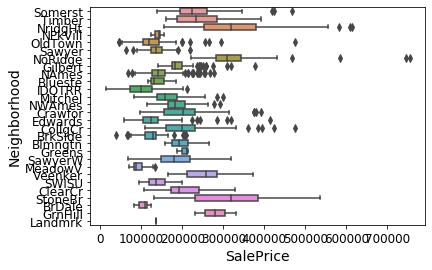

In [99]:
ax = sns.boxplot(x="SalePrice", y="Neighborhood", data=ames, orient="h")

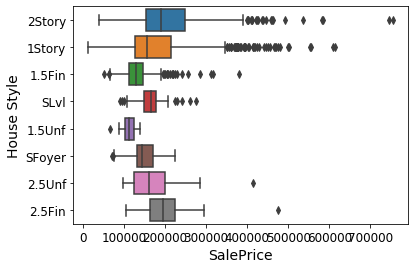

In [100]:
ax = sns.boxplot(x="SalePrice", y="House Style", data=ames, orient="h")

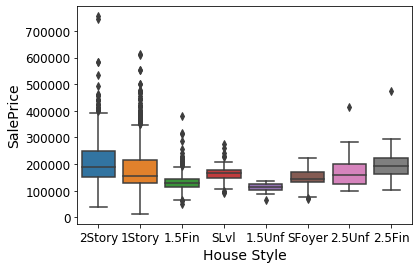

In [101]:
ax = sns.boxplot(x="House Style", y="SalePrice", data=ames, orient="v")

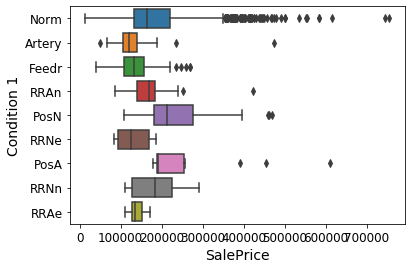

In [102]:
ax = sns.boxplot(x="SalePrice", y="Condition 1", data=ames, orient="h")

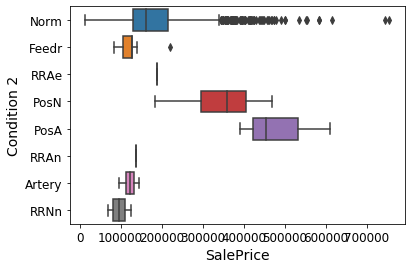

In [103]:
ax = sns.boxplot(x="SalePrice", y="Condition 2", data=ames, orient="h")

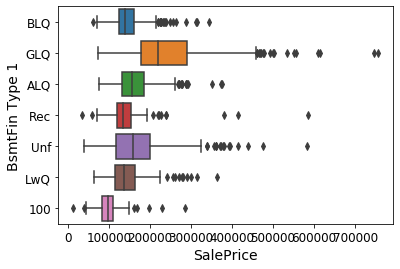

In [104]:
ax = sns.boxplot(x="SalePrice", y="BsmtFin Type 1", data=ames)

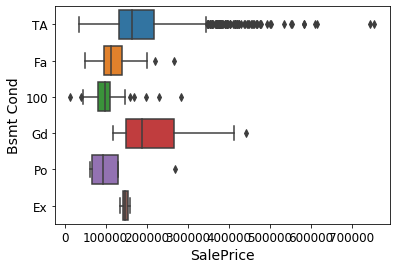

In [105]:
ax = sns.boxplot(x="SalePrice", y="Bsmt Cond", data=ames, orient="h")

In [253]:
ax = sns.boxplot(x="SalePrice", y="Bsmt Qual", data=ames, orient="h")

ValueError: Could not interpret input 'Bsmt Qual'

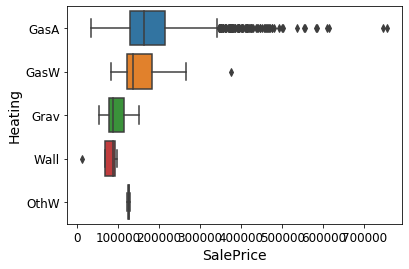

In [107]:
ax = sns.boxplot(x="SalePrice", y="Heating", data=traindata, orient="h")

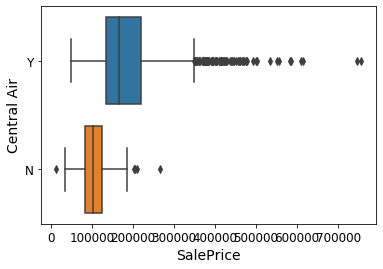

In [108]:
ax = sns.boxplot(x="SalePrice", y="Central Air", data=traindata, orient="h")

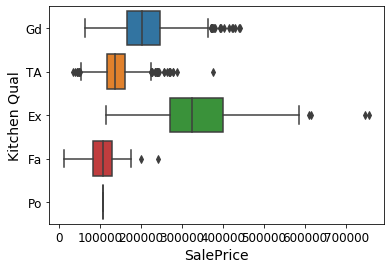

In [109]:
ax = sns.boxplot(x="SalePrice", y="Kitchen Qual", data=traindata, orient="h")

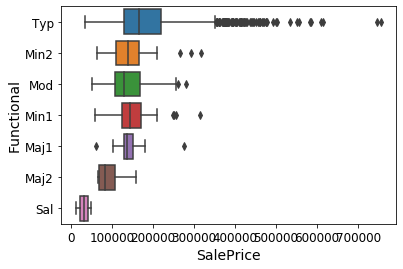

In [110]:
ax = sns.boxplot(x="SalePrice", y="Functional", data=traindata, orient="h")

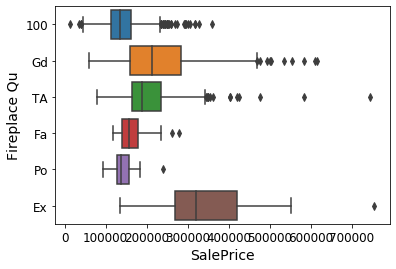

In [111]:
ax = sns.boxplot(x="SalePrice", y="Fireplace Qu", data=traindata, orient="h")

In [ ]:
min(traindata["Fireplaces"])

In [ ]:
max(traindata["Fireplaces"])

### Variabelen weglaten uit de analyses

Er worden een aantal categorische variabelen niet meegenomen omdat we bij het exploreren van de boxplots hebben gezien dat deze variabelen niet veel verband lijken te hebben met de uitkomst variabele SalesPrice.
Ook laten we de variabelen `Order` en `PID` weg omdat dit administratieve nummers van de huizen zijn, die geen relatie hebben met de uitkomst maat.

## Vervang missende waarden

Maak van de object data types "category" data types.

In [254]:
# objects to categorical
traindata[traindata.select_dtypes(include='object').columns] = traindata.select_dtypes(include='object').astype('category')

testdata[testdata.select_dtypes(include='object').columns] = testdata.select_dtypes(include='object').astype('category')

In [255]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 64 columns):
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null category
Lot Frontage       2051 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null category
Lot Shape          2051 non-null category
Land Contour       2051 non-null category
Utilities          2051 non-null category
Lot Config         2051 non-null category
Land Slope         2051 non-null category
Neighborhood       2051 non-null category
Bldg Type          2051 non-null category
House Style        2051 non-null category
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         2051 non-null category
Roof Matl          2051 non-null category
Exterior 1st       2051 non-null category
Exterior 2nd       2051 non-null category
Mas Vnr Type       2051 non-nu

In [256]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 879 entries, 547 to 2745
Data columns (total 64 columns):
MS SubClass        879 non-null int64
MS Zoning          879 non-null category
Lot Frontage       879 non-null float64
Lot Area           879 non-null int64
Street             879 non-null category
Lot Shape          879 non-null category
Land Contour       879 non-null category
Utilities          879 non-null category
Lot Config         879 non-null category
Land Slope         879 non-null category
Neighborhood       879 non-null category
Bldg Type          879 non-null category
House Style        879 non-null category
Overall Qual       879 non-null int64
Overall Cond       879 non-null int64
Year Built         879 non-null int64
Year Remod/Add     879 non-null int64
Roof Style         879 non-null category
Roof Matl          879 non-null category
Exterior 1st       879 non-null category
Exterior 2nd       879 non-null category
Mas Vnr Type       879 non-null category
Mas Vnr A

We vragen een correlatie heatmap op van de gehele training data set. We kiezen voor een heatmap vanwege het grote aantal variabelen (82).

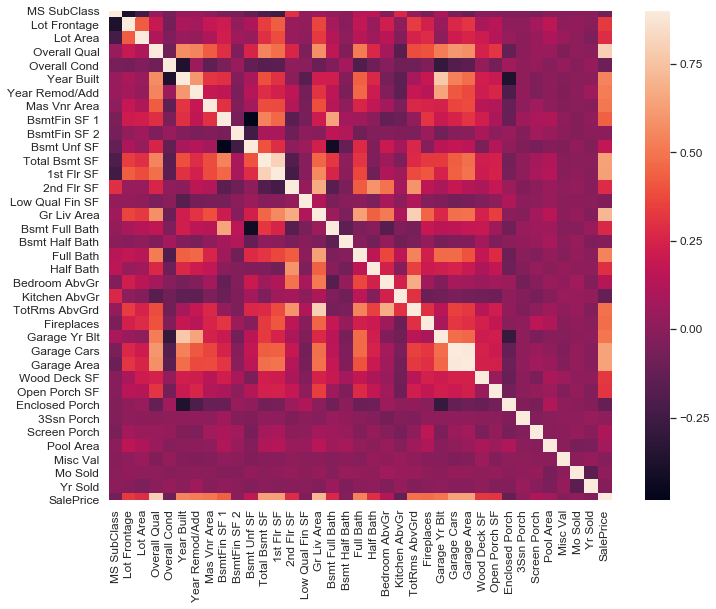

In [258]:
corrmat = traindata.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.9, square=True);


**Conclusies van de correlatiematrix**

De volgende variabelen hebben een hoge correlatie met SalePrice:
`Overall Qual`, `Year Built`, `Year Remod/Add`, `Total Bsmt SF`, `1st Flr SF`, `Gr Liv Area`, `Garage Cars`, `Garage Area`

De correlaties zijn overwegend positief, er zijn een aantal hoge positieve correlaties (> 0.75), maar er zijn geen hoge negatieve correlaties en relatief minder negatieve correlaties. 

Verder valt op dat er een aantal predictoren onderling hoge correlaties hebben:
`Garage Year Blt` en `Year Built`;
`Gr. Liv Area` en `TotRms AbvGrd`;
`Garage Cars` en `Garage Area`;
`1st Flr SF` en `Total Bsmt SF`.


Het is toch lastig om in de heatmap een aantal variabelen te selecteren met die een hoge correlatie hebben met de uitkomst maat. Daarom een heatmap van de 10 grootste correlaties. 

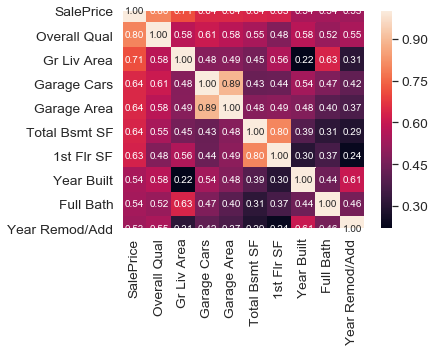

In [259]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k,'SalePrice')['SalePrice'].index
cm = np.corrcoef(traindata[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

We inspecteren de verdeling van de continue variabelen die voorkomen in de vorige heatmap plot van de 10 hoogste correlaties met de uitkomst maat. 

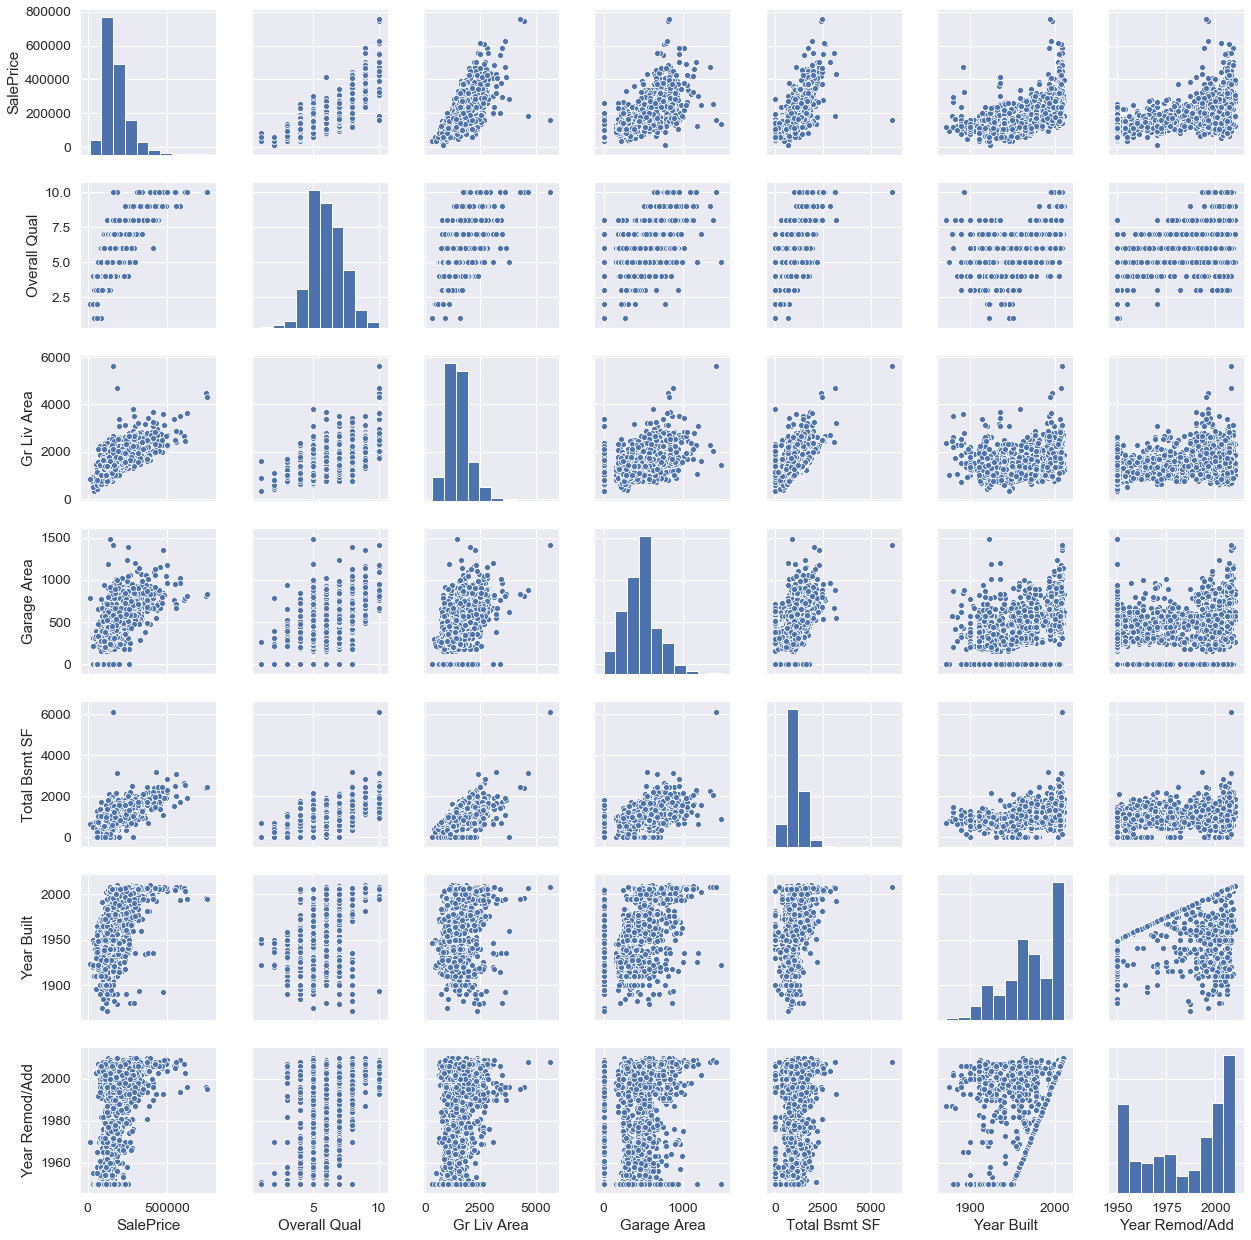

In [260]:
sns.pairplot(traindata[['SalePrice','Overall Qual','Gr Liv Area','Garage Area','Total Bsmt SF',
                        'Year Built', 'Year Remod/Add']]);

In [281]:
import sklearn
#from sklearn.utils import estimator_html_repr
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline 
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [283]:
# prepare X and y, using log(SalePrice) throughout
X_train = traindata[traindata.columns.drop('SalePrice')]
y_train = np.log(traindata['SalePrice'])

# same for test set
X_test = testdata[testdata.columns.drop('SalePrice')]
y_test = np.log(testdata['SalePrice'])

# read https://numpy.org/doc/stable/reference/arrays.scalars.html
# for understanding NumPy dtype hierarchy
cat_cols = X_train.select_dtypes(include='category').columns
num_cols = X_train.select_dtypes(exclude='category').columns

In [268]:
category_encoder = OneHotEncoder(drop='first')
category_encoder.fit(X_train)
X = category_encoder.transform(X_train)
X

<2051x9214 sparse matrix of type '<class 'numpy.float64'>'
	with 94722 stored elements in Compressed Sparse Row format>

In [270]:
print(X[0:3, 0:9])

  (0, 4)	1.0
  (1, 3)	1.0
  (2, 4)	1.0


In [273]:
X_cat_pipe = make_pipeline(OneHotEncoder(drop='first'))
X_cat_pipe

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(categorical_features=None, categories=None,
                               drop='first', dtype=<class 'numpy.float64'>,
                               handle_unknown='error', n_values=None,
                               sparse=True))],
         verbose=False)

In [274]:
X_num_pipe = make_pipeline(StandardScaler())
X_num_pipe

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True))],
         verbose=False)

### Creating dummy variables with `pandas.get_dummies`



In [ ]:
# using the information in this blog to create dummy variables with the first level dropped (or the last)
# https://towardsdatascience.com/encoding-categorical-features-21a2651a065c

categorical_feature_mask = X.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = X.columns[categorical_feature_mask].tolist()

In [291]:
# Get dummies
X_copy = X_train.copy()

categorical_select = X_copy.dtypes==object
#print(categorical_select)

categorical_cols = X_copy.columns[categorical_select].tolist()
print(categorical_cols)

X_copy = pd.get_dummies(X_copy, prefix_sep='_', drop_first=True)

X_copy.head()



['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Foundation', 'Kitchen Qual', 'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Sale Type', 'Sale Condition']


,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,...,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,90,82.0,6270,5,6,1949,1950,0.0,284.0,0.0,...,0,0,0,0,1,0,0,0,1,0
1,20,65.0,25095,5,8,1968,2003,0.0,1324.0,0.0,...,0,0,0,0,1,0,0,0,0,1
2,60,60.0,8238,6,5,1997,1998,0.0,700.0,0.0,...,0,0,0,0,1,0,0,0,1,0
3,120,35.0,3907,8,5,1989,1989,0.0,76.0,0.0,...,0,0,0,0,1,0,0,0,1,0
4,120,68.0,3072,7,5,2004,2004,18.0,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0


In [286]:
X_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Columns: 193 entries, MS SubClass to Sale Condition_Partial
dtypes: float64(11), int64(25), uint8(157)
memory usage: 891.4 KB


In [288]:
X_copy.keys()

Index(['MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2',
       ...
       'Sale Type_ConLI', 'Sale Type_ConLw', 'Sale Type_New', 'Sale Type_Oth',
       'Sale Type_WD ', 'Sale Condition_AdjLand', 'Sale Condition_Alloca',
       'Sale Condition_Family', 'Sale Condition_Normal',
       'Sale Condition_Partial'],
      dtype='object', length=193)

In [289]:
"Sale Condition" in X_copy

False

In [290]:
"Sale Type" in X_copy

False

In [292]:
X_train.columns

Index(['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope',
       'Neighborhood', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual',
       'Garage Cond', 'Paved Drive', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val',
       'Mo